In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadahmedansari/urdu-dataset-20000")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'urdu-dataset-20000' dataset.
Path to dataset files: /kaggle/input/urdu-dataset-20000


In [2]:

# ============================================================================
# CELL 2: Explore Dataset Structure
# ============================================================================
import pandas as pd
import os

# List all files in the downloaded path
print("Files in dataset directory:")
for file in os.listdir(path):
    print(f"  - {file}")

# Find and load TSV files
tsv_files = [f for f in os.listdir(path) if f.endswith('.tsv')]
print(f"\nFound {len(tsv_files)} TSV file(s): {tsv_files}")

# Load the first TSV file
if tsv_files:
    df = pd.read_csv(os.path.join(path, tsv_files[0]), sep='\t')

    print(f"\n{'='*70}")
    print("DATASET OVERVIEW")
    print(f"{'='*70}")
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
    print(f"\nColumn names:")
    for i, col in enumerate(df.columns):
        print(f"  {i}: {col}")

    print(f"\n{'='*70}")
    print("FIRST 5 ROWS")
    print(f"{'='*70}")
    print(df.head())

    print(f"\n{'='*70}")
    print("DATA TYPES")
    print(f"{'='*70}")
    print(df.dtypes)

    print(f"\n{'='*70}")
    print("MISSING VALUES")
    print(f"{'='*70}")
    print(df.isnull().sum())

    print(f"\n{'='*70}")
    print("SAMPLE DATA (Random 3 rows)")
    print(f"{'='*70}")
    print(df.sample(3))

    print(f"\n{'='*70}")
    print("BASIC STATISTICS")
    print(f"{'='*70}")
    if df.select_dtypes(include=['object']).shape[1] > 0:
        text_col = df.select_dtypes(include=['object']).columns[0]
        print(f"\nText column: '{text_col}'")
        print(f"Sample text: {df[text_col].iloc[0]}")
        print(f"\nText lengths (characters):")
        text_lengths = df[text_col].astype(str).str.len()
        print(f"  Min: {text_lengths.min()}")
        print(f"  Max: {text_lengths.max()}")
        print(f"  Mean: {text_lengths.mean():.2f}")
        print(f"  Median: {text_lengths.median():.2f}")
else:
    print("No TSV files found!")



Files in dataset directory:
  - final_main_dataset.tsv
  - model_checkpoint_v2.h5
  - char_to_num_vocab.pkl
  - limited_wav_files

Found 1 TSV file(s): ['final_main_dataset.tsv']

DATASET OVERVIEW
Shape: 20000 rows × 11 columns

Column names:
  0: client_id
  1: path
  2: sentence
  3: up_votes
  4: down_votes
  5: age
  6: gender
  7: accents
  8: variant
  9: locale
  10: segment

FIRST 5 ROWS
                                           client_id  \
0  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
1  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
2  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
3  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   
4  e53f84d151d6cc6d45a57decde08a99efe47d7751a4ca6...   

                           path  \
0  common_voice_ur_31771683.mp3   
1  common_voice_ur_31771684.mp3   
2  common_voice_ur_31771685.mp3   
3  common_voice_ur_31771730.mp3   
4  common_voice_ur_31771732.mp3   

                                            sentence 

In [3]:
# ============================================================================
# CELL 3: Import Required Libraries
# ============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# ============================================================================
# CELL 4: Urdu Text Preprocessing Functions
# ============================================================================
import unicodedata

def normalize_urdu_text(text):
    """Normalize Urdu text: remove diacritics, standardize Alef and Yeh"""
    if not isinstance(text, str):
        return ""

    # Remove diacritics
    text = ''.join(char for char in text if unicodedata.category(char) != 'Mn')

    # Standardize Alef forms
    alef_forms = ['آ', 'أ', 'إ', 'ا']
    for alef in alef_forms:
        text = text.replace(alef, 'ا')

    # Standardize Yeh forms
    yeh_forms = ['ی', 'ي', 'ے']
    for yeh in yeh_forms:
        text = text.replace(yeh, 'ی')

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize_urdu(text):
    """Simple word-level tokenization for Urdu"""
    text = normalize_urdu_text(text)
    tokens = re.findall(r'\S+', text)
    return tokens

# Test the functions
print("Testing preprocessing functions:")
test_text = "یہ ایک ٹیسٹ جملہ ہے۔"
print(f"Original: {test_text}")
print(f"Normalized: {normalize_urdu_text(test_text)}")
print(f"Tokens: {tokenize_urdu(test_text)}")


Testing preprocessing functions:
Original: یہ ایک ٹیسٹ جملہ ہے۔
Normalized: یہ ایک ٹیسٹ جملہ ہی۔
Tokens: ['یہ', 'ایک', 'ٹیسٹ', 'جملہ', 'ہی۔']


In [5]:

# ============================================================================
# CELL 5: Load Dataset and Filter Text
# ============================================================================
# Load dataset (already loaded in Cell 2, but loading again for clarity)
df = pd.read_csv(os.path.join(path, 'final_main_dataset.tsv'), sep='\t')

# Use only the 'sentence' column for text generation
text_data = df['sentence'].dropna().tolist()

print(f"Total sentences: {len(text_data)}")
print(f"\nSample sentences:")
for i, sent in enumerate(text_data[:5], 1):
    print(f"{i}. {sent}")


Total sentences: 20000

Sample sentences:
1. کبھی کبھار ہی خیالی پلاو بناتا ہوں
2. اور پھر ممکن ہے کہ پاکستان بھی ہو
3. یہ فیصلہ بھی گزشتہ دو سال میں
4. ان کے بلے بازوں کے سامنے ہو گا
5. آبی جانور میں بطخ بگلا اور دُوسْرا آبی پرندہ شامل ہونا


In [6]:
# ============================================================================
# CELL 6: Build Vocabulary
# ============================================================================
class Vocabulary:
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3}
        self.idx2word = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>'}
        self.word_count = {}
        self.n_words = 4

    def add_sentence(self, sentence):
        for word in tokenize_urdu(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

vocab = Vocabulary()
print("Building vocabulary...")
for text in tqdm(text_data, desc="Processing sentences"):
    vocab.add_sentence(str(text))

print(f"\nVocabulary size: {vocab.n_words}")
print(f"\nMost common words:")
common_words = sorted(vocab.word_count.items(), key=lambda x: x[1], reverse=True)[:10]
for word, count in common_words:
    print(f"  {word}: {count}")



Building vocabulary...


Processing sentences: 100%|██████████| 20000/20000 [00:00<00:00, 35762.33it/s]


Vocabulary size: 10875

Most common words:
  کی: 8415
  میں: 4162
  ہی: 3471
  کا: 3223
  سی: 3038
  ہی۔: 2683
  کو: 2065
  اور: 1894
  اس: 1863
  یہ: 1641


In [7]:
# ============================================================================
# CELL 7: Dataset Split (80% Train, 10% Val, 10% Test)
# ============================================================================
# Create a dataframe with sentences
sentences_df = pd.DataFrame({'sentence': text_data})

# Split data
train_data, temp_data = train_test_split(sentences_df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Training samples: 16000
Validation samples: 2000
Test samples: 2000


In [8]:
# ============================================================================
# CELL 8: PyTorch Dataset Class
# ============================================================================
class UrduDataset(Dataset):
    def __init__(self, dataframe, vocab, max_len=50):
        self.data = dataframe.reset_index(drop=True)
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['sentence'])
        tokens = tokenize_urdu(text)

        # Convert to indices
        indices = [self.vocab.word2idx.get(token, self.vocab.word2idx['<UNK>'])
                   for token in tokens]

        # Add SOS and EOS
        indices = [self.vocab.word2idx['<SOS>']] + indices + [self.vocab.word2idx['<EOS>']]

        # Pad or truncate
        if len(indices) < self.max_len:
            indices += [self.vocab.word2idx['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]

        # Input is all tokens except last, target is all tokens except first
        return torch.tensor(indices[:-1]), torch.tensor(indices[1:])

# Create datasets
train_dataset = UrduDataset(train_data, vocab)
val_dataset = UrduDataset(val_data, vocab)
test_dataset = UrduDataset(test_data, vocab)

print("Datasets created successfully!")
print(f"\nSample data point:")
src, tgt = train_dataset[0]
print(f"Input shape: {src.shape}")
print(f"Target shape: {tgt.shape}")


Datasets created successfully!

Sample data point:
Input shape: torch.Size([49])
Target shape: torch.Size([49])


In [9]:
# ============================================================================
# CELL 9: Positional Encoding
# ============================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

print("Positional Encoding defined!")


Positional Encoding defined!


In [10]:
# ============================================================================
# CELL 10: Transformer Encoder Layer
# ============================================================================
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        # Self attention
        attn_output, _ = self.self_attn(x, x, x, key_padding_mask=src_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

print("Transformer Encoder Layer defined!")


Transformer Encoder Layer defined!


In [11]:
# ============================================================================
# CELL 11: Transformer Decoder Layer
# ============================================================================
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, tgt_mask=None, src_mask=None):
        # Self attention
        attn_output, _ = self.self_attn(x, x, x, attn_mask=tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Cross attention
        attn_output, _ = self.cross_attn(x, encoder_output, encoder_output, key_padding_mask=src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))

        return x

print("Transformer Decoder Layer defined!")


Transformer Decoder Layer defined!


In [12]:
# ============================================================================
# CELL 12: Complete Transformer Model
# ============================================================================
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, n_heads=2, n_encoder_layers=2,
                 n_decoder_layers=2, d_ff=512, dropout=0.1, max_len=50):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_encoder_layers)
        ])

        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_decoder_layers)
        ])

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, src, tgt):
        # Create masks
        src_mask = (src == 0)  # Padding mask
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        # Encode
        src_emb = self.dropout(self.pos_encoding(self.embedding(src) * math.sqrt(self.d_model)))
        encoder_output = src_emb
        for layer in self.encoder_layers:
            encoder_output = layer(encoder_output, src_mask)

        # Decode
        tgt_emb = self.dropout(self.pos_encoding(self.embedding(tgt) * math.sqrt(self.d_model)))
        decoder_output = tgt_emb
        for layer in self.decoder_layers:
            decoder_output = layer(decoder_output, encoder_output, tgt_mask, src_mask)

        output = self.fc_out(decoder_output)
        return output

print("Transformer model defined successfully!")



Transformer model defined successfully!


In [13]:
# ============================================================================
# CELL 13: Training Configuration
# ============================================================================
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 3e-4
NUM_EPOCHS = 20
D_MODEL = 256
N_HEADS = 2
N_ENCODER_LAYERS = 2
N_DECODER_LAYERS = 2
DROPOUT = 0.2
MAX_LEN = 50

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model
model = Transformer(
    vocab_size=vocab.n_words,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_encoder_layers=N_ENCODER_LAYERS,
    n_decoder_layers=N_DECODER_LAYERS,
    d_ff=D_MODEL * 2,
    dropout=DROPOUT,
    max_len=MAX_LEN
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Training configuration set!")


Model parameters: 8,214,651
Training configuration set!


In [14]:
# ============================================================================
# CELL 14: Training Functions
# ============================================================================
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for src, tgt in tqdm(dataloader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])

        loss = criterion(output.reshape(-1, vocab.n_words), tgt[:, 1:].reshape(-1))
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in tqdm(dataloader, desc="Evaluating"):
            src, tgt = src.to(device), tgt.to(device)

            output = model(src, tgt[:, :-1])
            loss = criterion(output.reshape(-1, vocab.n_words), tgt[:, 1:].reshape(-1))

            total_loss += loss.item()

    return total_loss / len(dataloader)

print("Training functions defined!")



Training functions defined!


In [15]:
# ============================================================================
# CELL 15: Train the Model and Save Best Weights
# ============================================================================
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Perplexity: {math.exp(train_loss):.4f} | Val Perplexity: {math.exp(val_loss):.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab': vocab,
            'hyperparameters': {
                'd_model': D_MODEL,
                'n_heads': N_HEADS,
                'n_encoder_layers': N_ENCODER_LAYERS,
                'n_decoder_layers': N_DECODER_LAYERS,
                'dropout': DROPOUT,
                'max_len': MAX_LEN
            }
        }, 'best_urdu_transformer.pt')
        print(f"✓ Best model saved! (Val Loss: {val_loss:.4f})")

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation perplexity: {math.exp(best_val_loss):.4f}")
print("Model saved as 'best_urdu_transformer.pt'")




Epoch 1/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 91.74it/s]


Train Loss: 6.1877 | Val Loss: 5.4319
Train Perplexity: 486.7082 | Val Perplexity: 228.5799
✓ Best model saved! (Val Loss: 5.4319)

Epoch 2/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 77.97it/s]


Train Loss: 5.2596 | Val Loss: 4.8614
Train Perplexity: 192.4017 | Val Perplexity: 129.2037
✓ Best model saved! (Val Loss: 4.8614)

Epoch 3/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 101.51it/s]


Train Loss: 4.7119 | Val Loss: 4.3870
Train Perplexity: 111.2586 | Val Perplexity: 80.3951
✓ Best model saved! (Val Loss: 4.3870)

Epoch 4/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 98.92it/s]


Train Loss: 4.2310 | Val Loss: 4.0264
Train Perplexity: 68.7851 | Val Perplexity: 56.0610
✓ Best model saved! (Val Loss: 4.0264)

Epoch 5/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 96.58it/s]


Train Loss: 3.7992 | Val Loss: 3.6120
Train Perplexity: 44.6675 | Val Perplexity: 37.0402
✓ Best model saved! (Val Loss: 3.6120)

Epoch 6/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 78.45it/s]


Train Loss: 3.3820 | Val Loss: 3.2599
Train Perplexity: 29.4284 | Val Perplexity: 26.0482
✓ Best model saved! (Val Loss: 3.2599)

Epoch 7/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 100.22it/s]


Train Loss: 2.9792 | Val Loss: 2.9420
Train Perplexity: 19.6717 | Val Perplexity: 18.9531
✓ Best model saved! (Val Loss: 2.9420)

Epoch 8/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 101.53it/s]


Train Loss: 2.6336 | Val Loss: 2.6820
Train Perplexity: 13.9244 | Val Perplexity: 14.6139
✓ Best model saved! (Val Loss: 2.6820)

Epoch 9/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 101.66it/s]


Train Loss: 2.3157 | Val Loss: 2.4598
Train Perplexity: 10.1317 | Val Perplexity: 11.7028
✓ Best model saved! (Val Loss: 2.4598)

Epoch 10/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 74.82it/s]


Train Loss: 2.0420 | Val Loss: 2.2688
Train Perplexity: 7.7056 | Val Perplexity: 9.6678
✓ Best model saved! (Val Loss: 2.2688)

Epoch 11/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 101.42it/s]


Train Loss: 1.8288 | Val Loss: 2.1165
Train Perplexity: 6.2263 | Val Perplexity: 8.3017
✓ Best model saved! (Val Loss: 2.1165)

Epoch 12/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 97.74it/s]


Train Loss: 1.6403 | Val Loss: 1.9979
Train Perplexity: 5.1565 | Val Perplexity: 7.3732
✓ Best model saved! (Val Loss: 1.9979)

Epoch 13/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 87.62it/s]


Train Loss: 1.4850 | Val Loss: 1.8964
Train Perplexity: 4.4152 | Val Perplexity: 6.6616
✓ Best model saved! (Val Loss: 1.8964)

Epoch 14/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 99.93it/s] 


Train Loss: 1.3549 | Val Loss: 1.8466
Train Perplexity: 3.8765 | Val Perplexity: 6.3383
✓ Best model saved! (Val Loss: 1.8466)

Epoch 15/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 99.38it/s] 


Train Loss: 1.2496 | Val Loss: 1.7970
Train Perplexity: 3.4889 | Val Perplexity: 6.0318
✓ Best model saved! (Val Loss: 1.7970)

Epoch 16/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 99.63it/s]


Train Loss: 1.1570 | Val Loss: 1.7470
Train Perplexity: 3.1804 | Val Perplexity: 5.7374
✓ Best model saved! (Val Loss: 1.7470)

Epoch 17/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 79.04it/s]


Train Loss: 1.0806 | Val Loss: 1.7298
Train Perplexity: 2.9464 | Val Perplexity: 5.6396
✓ Best model saved! (Val Loss: 1.7298)

Epoch 18/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 101.30it/s]


Train Loss: 1.0166 | Val Loss: 1.7011
Train Perplexity: 2.7638 | Val Perplexity: 5.4802
✓ Best model saved! (Val Loss: 1.7011)

Epoch 19/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 98.04it/s]


Train Loss: 0.9603 | Val Loss: 1.6930
Train Perplexity: 2.6125 | Val Perplexity: 5.4360
✓ Best model saved! (Val Loss: 1.6930)

Epoch 20/20


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 103.25it/s]


Train Loss: 0.9083 | Val Loss: 1.6904
Train Perplexity: 2.4802 | Val Perplexity: 5.4214
✓ Best model saved! (Val Loss: 1.6904)

Training completed!
Best validation loss: 1.6904
Best validation perplexity: 5.4214
Model saved as 'best_urdu_transformer.pt'


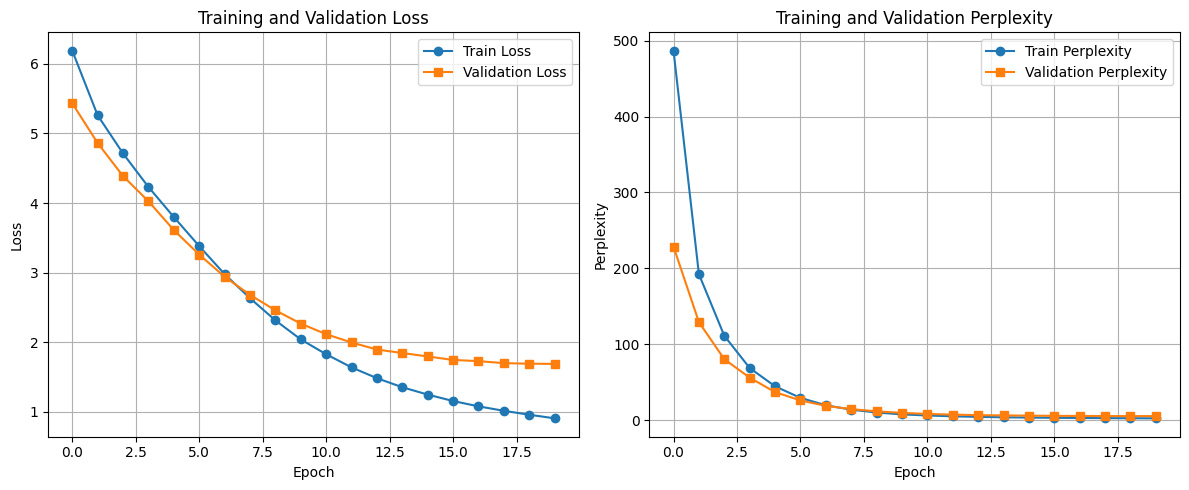

Training history plots saved!


In [16]:
# ============================================================================
# CELL 16: Plot Training History
# ============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
train_perplexity = [math.exp(loss) for loss in train_losses]
val_perplexity = [math.exp(loss) for loss in val_losses]
plt.plot(train_perplexity, label='Train Perplexity', marker='o')
plt.plot(val_perplexity, label='Validation Perplexity', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Training and Validation Perplexity')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved!")